## Tutorial of Causal Tracing

Causal tracing was a methodology for locating where facts are stored in transformer LMs, introduced in the paper ["Locating and Editing Factual Associations in GPT" (Meng et al., 2023)](https://arxiv.org/abs/2202.05262). In this notebook, we will implement their method using this library and replicate the first causal tracing example in the paper (full figure 1 on page 2).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frankaging/pyvene/blob/main/tutorials/advance_tutorials/Causal_Tracing.ipynb)

In [1]:
__author__ = "Aryaman Arora"
__version__ = "11/08/2023"

### Set-up

In [1]:
import pyvene

In [2]:
import torch
import pandas as pd
import numpy as np
from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import (
    IntervenableModel,
    VanillaIntervention, Intervention,
    RepresentationConfig,
    IntervenableConfig,
    ConstantSourceIntervention,
    LocalistRepresentationIntervention
)
from pyvene import create_gpt2

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
    xlab, ylab, ylim,
    scale_y_discrete, scale_y_continuous, ggsave
)
from plotnine.scales import scale_y_reverse, scale_fill_cmap
from tqdm import tqdm

titles={
    "block_output": "single restored layer in GPT2-XL",
    "mlp_activation": "center of interval of 10 patched mlp layer",
    "attention_output": "center of interval of 10 patched attn layer"
}

colors={
    "block_output": "Purples",
    "mlp_activation": "Greens",
    "attention_output": "Reds"
} 

### Factual recall

Let's set up the model (gpt2-xl) and test it on the fact we want to causal trace: "The Space Needle is in downtown **Seattle**".

### Clean run

In [3]:
#device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = "cpu"
config, tokenizer, gpt = create_gpt2(name="gpt2-xl")
#config, tokenizer, gpt = create_gpt2(name="gpt2")
gpt.to(device)

base = "The Space Needle is in downtown"
inputs = [tokenizer(base, return_tensors="pt").to(device)]
print(base)

loaded model
The Space Needle is in downtown


In [4]:
res = gpt(**inputs[0])

# convert an embedding to a distribution over the vocabulary
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

_Seattle             0.9763975143432617
_Bellev              0.0027683251537382603
_Portland            0.002157821087166667
,                    0.0015149710234254599
_Vancouver           0.0014351599384099245
_San                 0.0013576007913798094
_Minneapolis         0.0009382881689816713
.                    0.0007443605572916567
_Tacoma              0.000609736773185432
_Washington          0.0005885667633265257


## Corrupted run

The first step in implementing causal tracing is to corrupt the input embeddings for the subject tokens by adding Gaussian noise to them. In Meng et al., the standard deviation of the Gaussian we sample from is computed as thrice the standard deviation of embeddings over a big dataset. We encode this as a constant, `self.noise_level`.  -> **How sensitive is causal tracing results to this noise?**

Note that the `source` argument is ignored unlike in causal interventions, since we are adding noise without reference to any other input.

Our intervention config intervenes on the `block_input` of the 0th layer, i.e. the embeddings.

In [5]:
# ConstantSourceIntervention(Intervention) -> self.is_source_constant = True
# LocalistRepresentationIntervention(torch.nn.Module) -> self.is_repr_distributed = False
# forward method is not implemented ('pass') in Intervention

class NoiseIntervention(ConstantSourceIntervention, LocalistRepresentationIntervention):
    
    def __init__(self, embed_dim, **kwargs):
        super().__init__()
        self.interchange_dim = embed_dim
        rs = np.random.RandomState(1)
        prng = lambda *shape: rs.randn(*shape)
        self.noise = torch.from_numpy(prng(1, 4, embed_dim)).to(device)
        self.noise_level = 0.13462981581687927

    def forward(self, base, source=None, subspaces=None):
        base[..., : self.interchange_dim] += self.noise * self.noise_level
        return base

    # for printing class
    def __str__(self):
        return f"NoiseIntervention(embed_dim={self.embed_dim})"


# RepresentationConfig is a namedtuple
def corrupted_config(model_type):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                0,              # layer
                "block_input",  # component
            ),
        ],
        intervention_types=NoiseIntervention,
    )
    return config

Let's check that this reduced the probability of the output "_Seattle".

In [6]:
base = tokenizer("The Space Needle is in downtown", return_tensors="pt").to(device)
# type(gpt) -> transformers.models.gpt2.modeling_gpt2.GPT2Model
config = corrupted_config(type(gpt))

In [7]:
# IntervenableModel(BaseModel) -> Intervenable model via pyvene native backend (hook-based).
# BACKEND = "native"
# init calls super -> BaseModel

# BaseModel
# https://github.com/stanfordnlp/pyvene/blob/main/pyvene/models/intervenable_base.py
# forward not implemented, must be implemented in subclass
intervenable = IntervenableModel(config, gpt)

In [19]:
[None]*len(intervenable._intervention_group)

[None]

In [8]:
# to view settings print : config, intervenable.representations, intervenable.interventions, intervenable._intervention_group

In [9]:
# testing forward #

In [10]:
_, counterfactual_outputs = intervenable(base, unit_locations={"base": ([[[0, 1, 2, 3]]])})

{'base': [[[0, 1, 2, 3]]]}
{'sources->base': (None, [[[0, 1, 2, 3]]])}


NameError: name 'quit' is not defined

In [13]:
[[[0, 1, 2, 3]]][0][0]

[0, 1, 2, 3]

In [15]:
v = ([[[0, 1, 2, 3]]])
isinstance(v, list)

True

In [16]:
def get_list_depth(lst):
    """Return the max depth of the input list"""
    if isinstance(lst, list):
        return 1 + max((get_list_depth(item) for item in lst), default=0)
    return 0

get_list_depth(v)

3

In [ ]:
# test end #

In [ ]:
#  0, 1, 2, 3 -> "The Space Needle"
# Return: 
# base_output: the non-intervened output of the base input.
# counterfactual_outputs: the intervened output of the base input.
_, counterfactual_outputs = intervenable(base, unit_locations={"base": ([[[0, 1, 2, 3]]])})

distrib = embed_to_distrib(gpt, counterfactual_outputs.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

### Restored run

We now make a config that performs the following:
1. Corrupt input embeddings for some positions.
2. Restore the hidden state at a particular layer for some (potentially different positions).

This is how Meng et al. check where in the model the fact moves through.

In [30]:
def restore_corrupted_with_interval_config(
    layer, stream="mlp_activation", window=10, num_layers=48):
    start = max(0, layer - window // 2)
    end = min(num_layers, layer - (-window // 2))
    config = IntervenableConfig(
        representations=[
            RepresentationConfig(
                0,       # layer
                "block_input",  # intervention type
            ),
        ] + [
            RepresentationConfig(
                i,       # layer
                stream,  # intervention type
        ) for i in range(start, end)],
        intervention_types=\
            [NoiseIntervention]+[VanillaIntervention]*(end-start),
    )
    return config

Now let's run this over all layers and positions! We will corrupt positions 0, 1, 2, 3 ("The Space Needle", i.e. the subject of the fact) and restore at a single position at every layer.

In [31]:
# should finish within 1 min with a standard 12G GPU
token = tokenizer.encode(" Seattle")[0]
print(token)

7312


In [32]:
for stream in ["block_output", "mlp_activation", "attention_output"]:
    data = []
    for layer_i in tqdm(range(gpt.config.n_layer)):
        for pos_i in range(7):
            config = restore_corrupted_with_interval_config(
                layer_i, stream, 
                window=1 if stream == "block_output" else 10
            )
            n_restores = len(config.representations) - 1
            intervenable = IntervenableModel(config, gpt)
            _, counterfactual_outputs = intervenable(
                base,
                [None] + [base]*n_restores,
                {
                    "sources->base": (
                        [None] + [[[pos_i]]]*n_restores,
                        [[[0, 1, 2, 3]]] + [[[pos_i]]]*n_restores,
                    )
                },
            )
            distrib = embed_to_distrib(
                gpt, counterfactual_outputs.last_hidden_state, logits=False
            )
            prob = distrib[0][-1][token].detach().cpu().item()
            data.append({"layer": layer_i, "pos": pos_i, "prob": prob})
    df = pd.DataFrame(data)
    df.to_csv(f"./tutorial_data/pyvene_rome_{stream}.csv")

100%|████████████████████████████████████| 48/48 [08:38<00:00, 10.81s/it]


The plot below should now replicate Meng et al.

/home/drdo/anaconda3/envs/nlp/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 4 in image.
/home/drdo/anaconda3/envs/nlp/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_block_output.pdf
/tmp/ipykernel_17445/1409734670.py:24: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


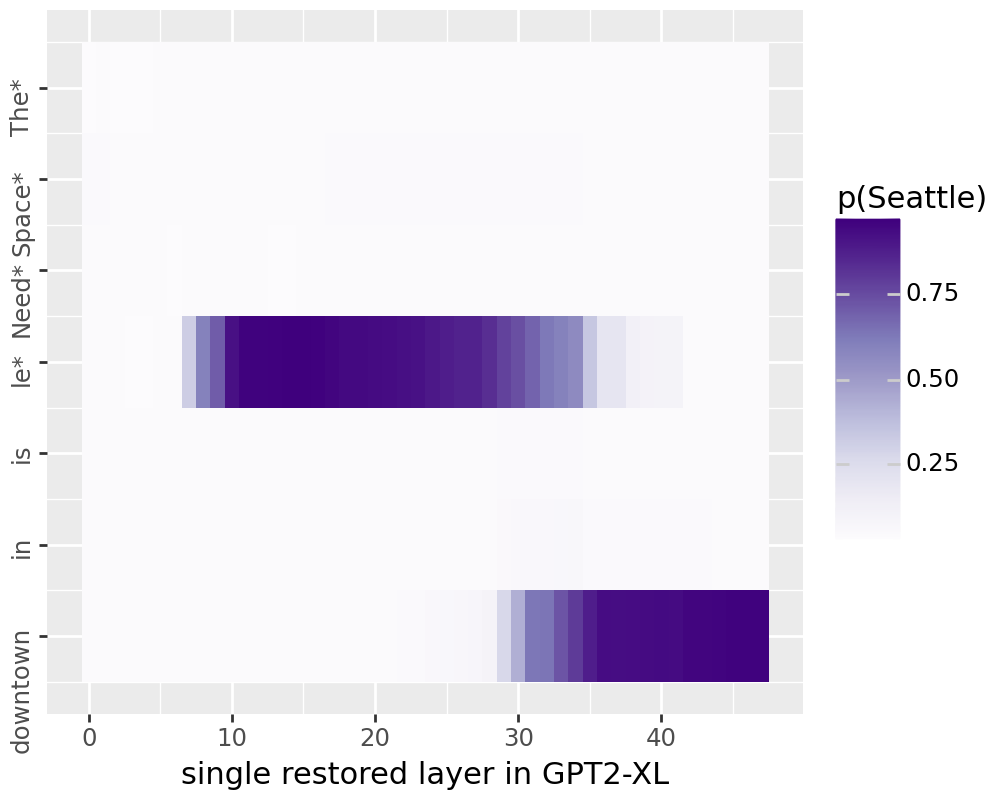

/home/drdo/anaconda3/envs/nlp/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 4 in image.
/home/drdo/anaconda3/envs/nlp/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_mlp_activation.pdf
/tmp/ipykernel_17445/1409734670.py:24: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


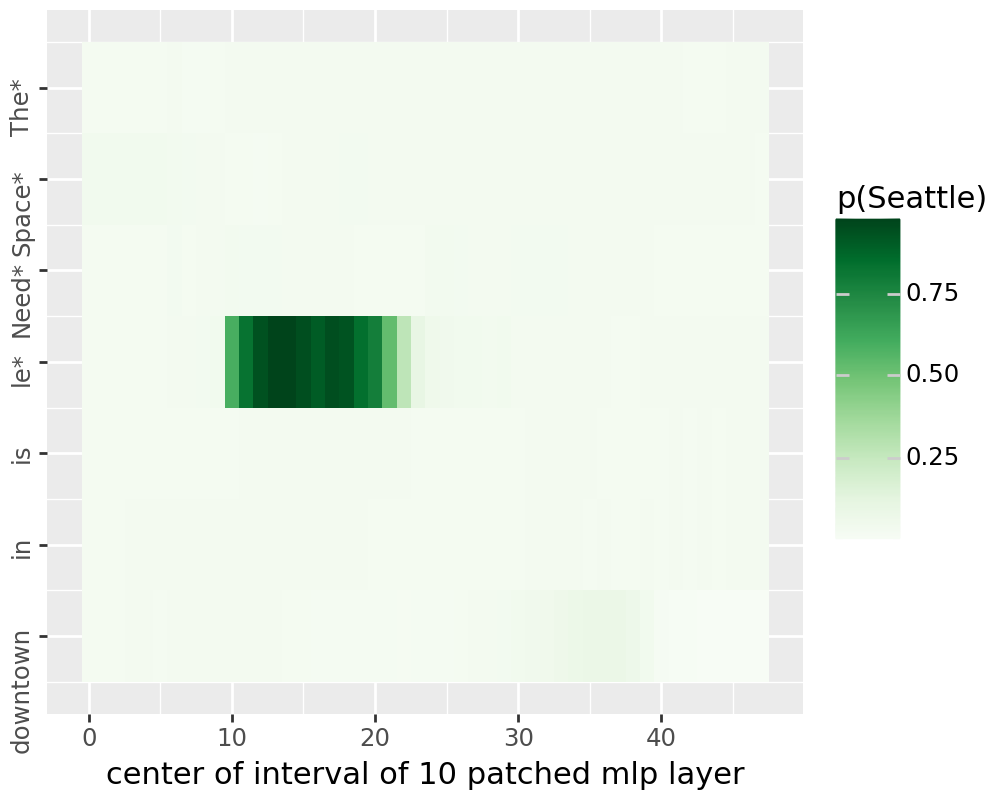

/home/drdo/anaconda3/envs/nlp/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 4 in image.
/home/drdo/anaconda3/envs/nlp/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_attention_output.pdf
/tmp/ipykernel_17445/1409734670.py:24: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


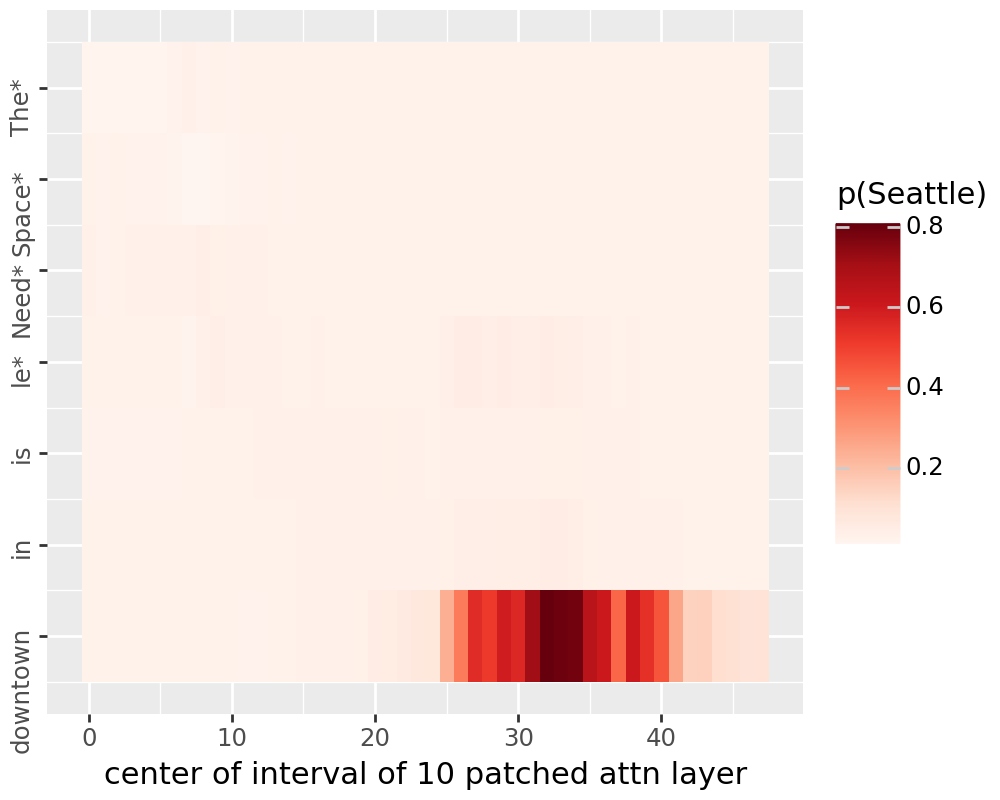

In [33]:
for stream in ["block_output", "mlp_activation", "attention_output"]:
    df = pd.read_csv(f"./tutorial_data/pyvene_rome_{stream}.csv")
    df["layer"] = df["layer"].astype(int)
    df["pos"] = df["pos"].astype(int)
    df["p(Seattle)"] = df["prob"].astype(float)

    custom_labels = ["The*", "Space*", "Need*", "le*", "is", "in", "downtown"]
    breaks = [0, 1, 2, 3, 4, 5, 6]

    plot = (
        ggplot(df, aes(x="layer", y="pos"))    

        + geom_tile(aes(fill="p(Seattle)"))
        + scale_fill_cmap(colors[stream]) + xlab(titles[stream])
        + scale_y_reverse(
            limits = (-0.5, 6.5), 
            breaks=breaks, labels=custom_labels) 
        + theme(figure_size=(5, 4)) + ylab("") 
        + theme(axis_text_y  = element_text(angle = 90, hjust = 1))
    )
    ggsave(
        plot, filename=f"./tutorial_data/pyvene_rome_{stream}.pdf", dpi=200
    )
    print(plot)